# Step5 演習04 双方向RNN（Bidirectional RNN）
---

本演習では、手書き数字のMNISTを双方向RNNを用いて分類します。

**はじめに**
- for文やwhile文の利用は明示的な利用指示がない場所での利用は避けてください。

**本演習の目的**
- RNNをnumpyのみで実装する

## ライブラリのインストール

まずはじめに、本演習で利用するライブラリのインポートを行います。

- [numpy](http://www.numpy.org) 数値計算を行うための基本パッケージの公式ドキュメント
- [matplotlib](http://matplotlib.org) グラフ描画ライブラリの基本パッケージの公式ドキュメント
- [tensorflow](https://www.tensorflow.org/) 機械学習用のライブラリの公式ドキュメント


`%matplotlib inline` はnotebook上で使える[magic function](http://ipython.readthedocs.io/en/stable/interactive/magics.html)の一つで、これによりmatplotlibをインタラクティブに使うことできます。

In [1]:
import numpy as np
%matplotlib inline 
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

## データセット
いままでと同様の方法でMNISTを読み込みます。

In [2]:
# データの読み込み
mnist = input_data.read_data_sets("MNIST_data/", 
                                  one_hot=True, 
                                  validation_size=0)

# データのシャッフル
permutation = np.random.permutation(mnist.train._images.shape[0])
mnist.train._images = mnist.train.images[permutation]
mnist.train._labels = mnist.train.labels[permutation]

#データの正規化
mean = np.mean(mnist.train.images)
std = np.std(mnist.train.images)
mnist.train._images = (mnist.train.images-mean)/std
mnist.test._images = (mnist.test.images-mean)/std

# データの形を整える
mnist.train._images = mnist.train._images.reshape(-1, 28, 28)
mnist.test._images = mnist.test._images.reshape(-1, 28, 28)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## モデルの構築

この演習では、下図のようなモデルを学習させます。

<img src="./img/step5_birnn.png" width="360" height="120">

入力はこれまでと同様にMNISTです。Step5 演習01では画像を上から順番に入れていき、最後の隠れ状態を使ってクラス分類しましが、ここでは、画像を上から入れていくRNN (forward)と画像を下から入れていくRNN (backward)の2つのRNNを使います。そして、それぞれの最後の隠れ状態を結合し、それを元にクラス分類します。

### モデルパラメータの準備

今回は下記のモデルパラメータを用います。隠れ層は100付近の値に設定します。

In [3]:
hidden_size = 100 # 隠れ層のサイズ
image_size = 28 # 入力画像のサイズ
class_num = 10 #　分類するカテゴリ数（0~9）

### モデルの重みの初期化

これまで同様にglorot_uniformでモデルパラメータを初期化します。ここでは、初期化関数を3つに分けて書きました。

`glorot_uniform`はこれは引数として`shape`を受け取りそれを元にパラメータを生成します。

`init_parameters`は2つのRNNのパラメータを初期化する際に使用します。これには最後の分類のためのパラメータは含みません。

`init_parameters_output`は分類をする際に必要なパラメータを初期化する際に使用します。

In [4]:
def glorot_uniform(shape):
    if len(shape) == 2:
        fan_in, fan_out = shape
        std = np.sqrt(6./(fan_in+fan_out))
        return np.random.uniform(low=-std, high=std, size=(fan_in, fan_out))
    else:
        raise NotImplementedError()

In [5]:
def init_parameters(image_size, hidden_size, class_num):
    #入力から隠れ層の重み
    U = glorot_uniform((image_size, hidden_size))

    #隠れ層から隠れ層の重み
    W = glorot_uniform((hidden_size, hidden_size)) 

    # 隠れ層のバイアス
    b = np.zeros((1, hidden_size))

    # Adamを使用するにあたって必要なパラメータの初期化a
    mU, mW = np.zeros_like(U), np.zeros_like(W)
    mb = np.zeros_like(b)
    vU, vW = np.zeros_like(U), np.zeros_like(W)
    vb = np.zeros_like(b)
        
    # パラメータをタプルにまとめます。
    params = (U, W, b)
    ms = (mU, mW, mb)
    vs = (vU, vW, vb)
    return params, ms, vs

In [6]:
def init_parameters_output(image_size, hidden_size, class_num):
    #隠れ層から出力層の重み
    V = glorot_uniform((hidden_size*2, class_num)) 

    # 出力層のバイアス
    c = np.zeros((1, class_num))

    # Adamを使用するにあたって必要なパラメータの初期化
    mV = np.zeros_like(V)
    mc = np.zeros_like(c)
    vV = np.zeros_like(V)
    vc = np.zeros_like(c)
    
    # パラメータをタプルにまとめます。
    params = (V, c)
    ms = (mV, mc)
    vs = (vV, vc)
    return params, ms, vs

### フォワードプロパゲーションの実装

**【課題１】**　ここではBiRNNの順伝播を実装します。

基本はこれまでの演習と同じですが、2つのRNNの出力を使ってクラス分類するのでここの箇所だけ少し異なります。

`forward_propagation`3つの引数があります。
- `X`: 入力画像（バッチサイズ、縦×横）
- `params`: `init_parameters`で用意した重みとバイアス
- `batch_size`: バッチサイズ

この関数内では、
- `params`は前向き、後ろ向き、出力層に必要なパラメータが格納されています。
- `h_f`: 前向きの隠れ層の値を記録するために空の辞書を用意します。
- `h_f[-1]`: フォワードプロパゲーションの１ステップに必要な値（ゼロ）をいれます。
- `h_b`: 後ろ向きの隠れ層の値を記録するために空の辞書を用意します。
- `h_b[28]`: フォワードプロパゲーションの１ステップに必要な値（ゼロ）をいれます。
- 前向きの計算をするためにforループで画像の縦分（２８）回します。ループ内では毎回、入力画像の１行分を（$\boldsymbol{x}^{(t)}$）としていれます。ここではまだ`X`は画像全体なので注意して扱ってください。
- `a_f`: $$\boldsymbol{a}^{(t)}=\boldsymbol{b}+\boldsymbol{h}^{(t-1)}\boldsymbol{W}+\boldsymbol{x}^{(t)}\boldsymbol{U}$$を計算します。
- `h_f[t]`: 隠れ状態を記録します。

後ろ向きも同様に計算し、`h_concat`で前向きと後ろ向きの最後の隠れ状態を結合します。その後、出力層で、
$$
\begin{eqnarray*}
\boldsymbol{o}&=&\boldsymbol{c}+\boldsymbol{hV}\\
\boldsymbol{\hat{y}}&=&softmax(\boldsymbol{o})
\end{eqnarray*}
$$
を計算し、最後にすべての隠れ状態を`h`に格納します。

In [7]:
#Coursedele-02 Step5 QuestionNumber10 546f2a2c5d1035d49738803969ad2c61
def softmax(x, axis=1):
    c = np.max(x)
    exp_x = np.exp(x - c)
    y = exp_x / np.sum(exp_x, axis=axis, keepdims=True) 
    return y

def forward_propagation(X, params, batch_size):
    U_f, W_f, b_f, U_b, W_b, b_b, V, c = params
    h_f, h_b = {}, {}
    h_f[-1] = np.zeros((batch_size, hidden_size))
    h_b[28] = np.zeros((batch_size, hidden_size))
    ###############START CODE HERE###############
    # 前向き
    for t in range(28):
        a_f = b_f + np.dot(h_f[t-1], W_f) + np.dot(X[:, t], U_f)
        h_f[t] = np.tanh(a_f)
    
    # 後ろ向き
    # 後ろ向きなので時間をプラス方向に動かすことに気を付けて下さい。h_b[t+1]のようにします。
    for t in reversed(range(28)):
        a_b = b_b + np.dot(h_b[t+1], W_b) + np.dot(X[:,t], U_b)
        h_b[t] = np.tanh(a_b)
        
    # 前向きの最後の隠れ状態（27番目）と後ろ向きの隠れ状態（0番目）を結合
    h_concat = np.concatenate([h_f[27], h_b[0]], axis = 1)
    
    # 出力層
    o = c + np.dot(h_concat, V)
    # ソフトマックス関数
    y_pred = softmax(o)
    ################END CODE HERE################
    h = (h_f, h_b, h_concat)
    return y_pred, X, h

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [32]:
%%bash
./validation_client.py dele-02 5 10 Step5_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



### コスト関数の計算

**【課題２】**　ここではコスト関数を実装します。この課題はStep5 演習01と同じです。

コスト関数には交差エントロピーを使います。
$$
cost = - \frac{1}{m}\sum_x y(x) \log{\hat{y}(x)}
$$

In [8]:
#Coursedele-02 Step5 QuestionNumber11 5d08ef1f874d5815b269ea181a74adc9
def compute_cost(y_pred, targets, batch_size):
    ###############START CODE HERE###############
    loss = -np.sum(np.log(y_pred) * targets) / float(batch_size)
    ################END CODE HERE################
    return loss

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [14]:
%%bash
./validation_client.py dele-02 5 11 Step5_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



### バックプロパゲーションの実装

**【課題３】**　ここではBiRNNのBPTTを実装します。

過去の演習で書いてきたコードを参考にすればそんなに難しくないはずです。ただ、これまでと少し異なるのは、`delta_h_concat`です。順伝播では`h_f`と`h_b`を結合したものが`h_concat`でした。なので、逆伝播では`delta_h_concat`を`delta_h_f`と`delta_h_b`に分離する必要があります。

In [9]:
#Coursedele-02 Step5 QuestionNumber12 4b1cb4371e3419be0e7670a372cad498
def backward_propagation(params, X, h, y_pred, targets):
    U_f, W_f, b_f, U_b, W_b, b_b, V, c = params
    batch_size = X.shape[0]
    h_f, h_b, h_concat = h

    delta_U_f, delta_W_f = np.zeros_like(U_f), np.zeros_like(W_f)
    delta_U_b, delta_W_b = np.zeros_like(U_b), np.zeros_like(W_b)
    delta_b_f, delta_b_b = np.zeros_like(b_f), np.zeros_like(b_b)
    
    # 出力層の逆伝播
    ###############START CODE HERE###############
    delta_o = (y_pred - targets) / float(batch_size)
    delta_V = np.dot(h_concat.T, delta_o)
    delta_c = np.sum(delta_o, axis = 0)
    delta_h_concat = np.dot(delta_o, V.T)
    ################END CODE HERE################
    
    # 前向きの逆伝播
    delta_h_next = np.zeros_like(h_f)
    for t in reversed(range(28)):
        ###############START CODE HERE###############
        if t == 27:
            # delta_h_concatの前半（0~99）まで使用、スライスの位置に注意
            delta_h_f = delta_h_concat[:, :100]
        else:
            delta_h_f = delta_h_next
        # tanhの逆伝播
        delta_a = (1 - h_f[t] * h_f[t]) * delta_h_f
        delta_b_f += np.sum(delta_a, axis = 0)
        delta_U_f +=np.dot(X[:, t].T, delta_a)
        delta_W_f +=np.dot(h_f[t-1].T, delta_a)
        delta_h_next =np.dot(delta_a, W_f.T)
        ################END CODE HERE################
        
    # 後ろ向きの逆伝播
    delta_h_next = np.zeros_like(h_b)
    for t in range(28):
        ###############START CODE HERE###############
        if t == 0:
            # delta_h_concatの後半（100~199）まで使用、スライスの位置に注意
            delta_h_b = delta_h_concat[:, 100:]
        else:
            delta_h_b =delta_h_next
        delta_a = (1 - h_b[t] * h_b[t]) * delta_h_b
        delta_b_b += np.sum(delta_a, axis = 0)
        delta_U_b += np.dot(X[:, t].T, delta_a)
        delta_W_b += np.dot(h_b[t + 1].T, delta_a)
        delta_h_next =np.dot(delta_a, W_b.T)
        ################END CODE HERE################
        
    grads_f = (delta_U_f, delta_W_f, delta_b_f)
    grads_b = (delta_U_b, delta_W_b, delta_b_b)
    grads_o = (delta_V, delta_c)
    grads = grads_f + grads_b + grads_o
    # 勾配をクリッピング
    for g in grads:
        np.clip(g, -1, 1, out=g)
    return grads

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [10]:
%%bash
./validation_client.py dele-02 5 12 Step5_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



### パラメータの更新

**【課題４】**　ADAMを実装します。この課題はStep5 演習01と全く同じです。


ここでは[ADAM](https://arxiv.org/pdf/1412.6980.pdf)でパラメータを更新します。
$$
\begin{eqnarray*}
\boldsymbol{m}_t &=& \beta_1 \boldsymbol{m}_{(t-1)} + (1-\beta_1)\boldsymbol{g}_t\\
\boldsymbol{v}_t &=& \beta_2 \boldsymbol{v}_{(t-1)} + (1-\beta_2)\boldsymbol{g}_t^2\\
\boldsymbol{\hat{m}}_t &=& \frac{\boldsymbol{m}_t}{(1-\beta_1^t)}\\
\boldsymbol{\hat{v}}_t &=& \frac{\boldsymbol{v}_t}{(1-\beta_2^t)}\\
\boldsymbol{p}_t &=& \boldsymbol{p}_{(t-1)} - \alpha \frac{\boldsymbol{\hat{m}_t}}{\sqrt{\boldsymbol{\hat{v}}_t}+\epsilon}
\end{eqnarray*}
$$

`update_parameters`は5つの引数があります。
- `params`: 重みとバイアス
- `grads`: 勾配
- `ms`, `vs`: ADAMを使って必要な値
- `iteration`: 現在のステップ数（ADAMのbias correction）

In [11]:
#Coursedele-02 Step5 QuestionNumber13 ae522082d3884a17e8b1885d3b2351f5
def update_parameters(params, grads, ms, vs, iteration):
    alpha = 0.001
    beta1 = 0.9
    beta2 = 0.999
    eps = 1e-8
    for num in range(len(params)):
        p, g, m, v = params[num], grads[num], ms[num], vs[num]
        ###############START CODE HERE###############
        # Adam
        m_t = beta1 * m + (1 - beta1) * g
        v_t = beta2 * v + (1 - beta2) * g * g
        m_t_hat = m_t / (1 - np.power(beta1, iteration))
        v_t_hat = v_t / (1 - np.power(beta2, iteration))
        params[num][:] = p - alpha * m_t_hat / (np.sqrt(v_t_hat) + eps)
        ################END CODE HERE################
        ms[num][:] = m_t
        vs[num][:] = v_t
    return params

** ファイルを保存後 **、次のセルを実行（Shift+Enter）で採点を行います。

In [18]:
%%bash
./validation_client.py dele-02 5 13 Step5_04.ipynb api.internal.zero2one.jp

Congratulations!
We give you 10 points out of 10 points.



## BiRNNの学習

### BiRNNの学習
作成したBiRNNをデータセットで学習させます。ここでは3エポックのみ学習させますが、通常のRNNよりもBiRNNの方が性能がいいはずです。

In [12]:
%%time
# バッチサイズ
batch_size = 250
# １エポックあたりのステップ数
total_step_train = int(len(mnist.train.labels)/batch_size)
# パラメータの初期化
params_f, ms_f, vs_f = init_parameters(image_size, hidden_size, class_num)
params_b, ms_b, vs_b = init_parameters(image_size, hidden_size, class_num)
params_o, ms_o, vs_o = init_parameters_output(image_size, hidden_size, class_num)
params = params_f + params_b + params_o
ms = ms_f + ms_b + ms_o
vs = vs_f + vs_b + vs_o

# ロス/精度を記録するための配列
train_loss = []
train_acc = []
for epoch in range(1):
    for iteration in range(total_step_train):
        inputs, targets = mnist.train.next_batch(batch_size, shuffle=False)
        # 順伝播
        y_pred, X, h = forward_propagation(inputs, params, batch_size)
        # コスト関数
        _loss = compute_cost(y_pred, targets, batch_size)
        # 逆伝播
        grads = backward_propagation(params, X, h, y_pred, targets)
        # パラメータのアップデート
        params = update_parameters(params, grads, ms, vs, 
                                   total_step_train*epoch+iteration+1)
        
        assert not np.isnan(_loss), 'nan in loss'
        # accuracyとlossを記録
        _acc = np.mean(np.argmax(y_pred, axis=1)==np.argmax(targets, axis=1))
        # ログをプリント
        if iteration % 10 == 0:
            print('\r \t iter: {}, loss: {:.3f}, acc: {:.3f}'.format(iteration, _loss, _acc), end='')
        train_loss.append(_loss)
        train_acc.append(_acc)
    print('\n{}: epoch, loss: {:.3f}, acc: {:.3f}'.format(epoch, 
                                                          np.mean(train_loss[total_step_train*epoch:]), 
                                                          np.mean(train_acc[total_step_train*epoch:])))

 	 iter: 230, loss: 0.240, acc: 0.924
0: epoch, loss: 0.557, acc: 0.828
CPU times: user 43.7 s, sys: 17.2 s, total: 1min
Wall time: 35.4 s


### 学習データの精度とロスのプロット

学習データの精度とロスをプロットしてみます。

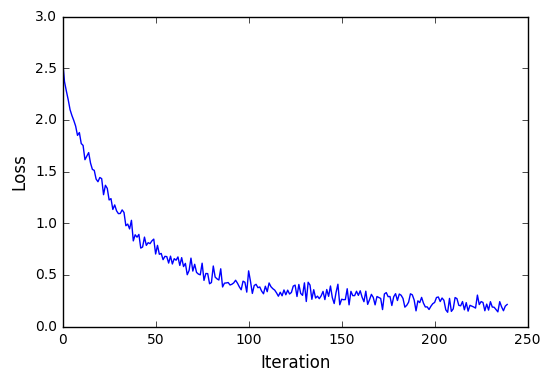

In [13]:
plt.plot(train_loss)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss', fontsize=12)

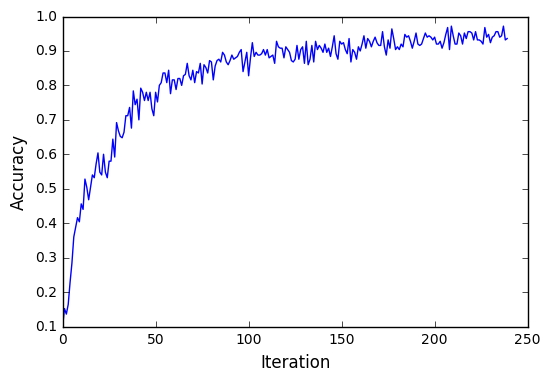

In [14]:
plt.plot(train_acc)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

### テストデータの精度とロスの計算

最後にテストデータの精度とロスを計算してみます。

In [15]:
test_loss = []
test_acc = []
inputs = mnist.test.images
targets = mnist.test.labels
batch_size = len(inputs)
y_pred, x, h = forward_propagation(inputs, params, batch_size)
# コスト関数
_loss = compute_cost(y_pred, targets, batch_size)

_acc = np.mean(np.argmax(y_pred, axis=1)==np.argmax(targets, axis=1))
test_loss.append(_loss)
test_acc.append(_acc)
# ログをプリント
print('loss: {:.3f}, acc: {:.3f}'.format(np.mean(test_loss), np.mean(test_acc)))

loss: 0.188, acc: 0.944
